# Automatization of the comments processing for the online store

# Content

1. [Project Description](#section_0)
2. [Data import and overview](#section_1)
3. [Data preparation](#section_2)
4. [Models training](#section_3)
5. [Model testing and drawing a conclusion](#section_4)

<a name ='section_0'></a>
# Project Description

Online store just to rolls out new service. With new service the clients can edit and add a description of the products in the store (same as in wiki services). Clients could suggest the edits of descriptions and comment the changes of other clients. Store would like to have a tool which can classify the comments on toxic and regular. It's required to train a model for the classification of future comments.  

Model F1 score shall no be less than 0.75. 

**Project tasks**

1. Import and prepare the data.
2. Train the models. 
3. Test the models and draw a conclusion.

**Data description**

Data stored in `toxic_comments.csv`. Column `text` contains a text, column `toxic` — target.

<a name = 'section_1'><a/>
# Data import and preparation

**Libraries and data import and overview**

In [1]:
import re
import nltk
import torch
import pandas as pd
import numpy as np
import transformers
from pymystem3 import Mystem
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from scipy.stats import randint
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv',index_col=[0])
except:
    data = pd.read_csv('toxic_comments.csv',index_col=[0])

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
data['toxic'].sum()

16186

**Conclusion:**

- data imported and overview completed;
- data has 2 columns - text and toxic (target)
- data has 159292 numbers of records.
- data has 16186 toxic comments - it's 10% of all records

<a name = 'section_2'></a>
# Data preparation

**Execution of lemmatization, tokenization and padding**

In [8]:
m = WordNetLemmatizer()

In [9]:
lem_text = []
for i in data['text']:
    word_list = nltk.word_tokenize(i)
    lemmatized_output = ' '.join([m.lemmatize(w) for w in word_list])
    temp = re.sub(r'[^a-zA-Z]', ' ', lemmatized_output)
    temp = temp.split()
    lem_text.append(" ".join(temp))

**Create a new column with lemmatized text**

In [10]:
data['lem_text'] = lem_text

In [11]:
data.head() 

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n t make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


**Added a new feature - text length**

In [12]:
length = []
for i in data['lem_text']:
    length.append(len(i))

In [13]:
data['length'] = length

In [14]:
data.describe()

,toxic,length
count,159292.000000,159292.000000
mean,0.101612,368.104820
std,0.302139,554.384726
min,0.000000,0.000000
25%,0.000000,87.000000
50%,0.000000,191.000000
75%,0.000000,409.000000
max,1.000000,5000.000000


In [15]:
# count quantity of record per length
data_length = data.groupby('length')['text'].count()
data_length

length
0       11
2        2
3        3
4       12
5       11
        ..
4991     1
4992     1
4996     1
4999    17
5000    16
Name: text, Length: 3944, dtype: int64

In [16]:
# display the sorted quantity of record per length
data_length.sort_values(ascending=False)

length
33      693
32      662
37      659
34      654
36      653
       ... 
2591      1
3535      1
3538      1
2589      1
3795      1
Name: text, Length: 3944, dtype: int64

In [17]:
# destribution infromation
data_length.describe()

count    3944.000000
mean       40.388438
std       101.472592
min         1.000000
25%         1.000000
50%         3.000000
75%        20.000000
max       693.000000
Name: text, dtype: float64

Text(0.5, 1.0, 'quantity of recrods and length of it')

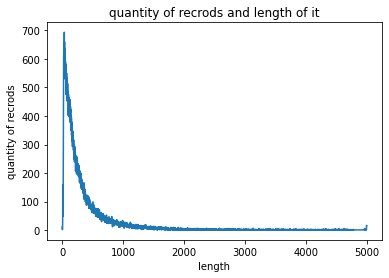

In [18]:
# plotting of length destribution
data_length.plot()
plt.xlabel('length')
plt.ylabel('quantity of recrods')
plt.title('quantity of recrods and length of it')

In [19]:
# deletion of recrods with huge length
corrected_data = data[data['length']<1450].copy()

In [20]:
corrected_data.describe()

,toxic,length
count,152956.000000,152956.000000
mean,0.102814,278.639674
std,0.303717,279.456468
min,0.000000,0.000000
25%,0.000000,84.000000
50%,0.000000,180.000000
75%,0.000000,367.000000
max,1.000000,1449.000000


Text(0.5, 1.0, 'quantity of recrods and length of it')

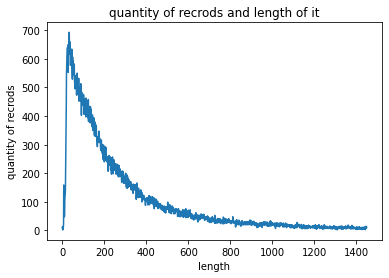

In [21]:
# plotting of length destribution
corrected_data.groupby('length')['text'].count().plot()
plt.xlabel('length')
plt.ylabel('quantity of recrods')
plt.title('quantity of recrods and length of it')

**Text vectorization**

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [24]:
n = 35000/corrected_data['lem_text'].count()

In [25]:
misc_data, data_train, misc_target, target_train = train_test_split(corrected_data['lem_text'],corrected_data['toxic'],test_size = n)
data_train, data_test, target_train, target_test = train_test_split(data_train,target_train,test_size = 0.08)

**Splitting data on train and test samples**

In [26]:
features_train = count_tf_idf.fit_transform(data_train).toarray()
features_test = count_tf_idf.transform(data_test).toarray()

In [27]:
features_train = pd.DataFrame(features_train)
features_train.index = target_train.index
features_test = pd.DataFrame(features_test)
features_test.index = target_test.index

<a name = 'section_3'></a>
# Models training

**Logistic Regression model training**

In [28]:
lr_model = LogisticRegression(random_state = 142)
lr_model.fit(features_train,target_train)
lr_model_score = lr_model.score(features_train,target_train)
lr_model_score

0.9495652173913044

**Combat to imbalance**

In [29]:
lr_balanced_model = LogisticRegression(random_state = 147,class_weight='balanced')
lr_balanced_model.fit(features_train,target_train)
lr_balanced_model_score = lr_balanced_model.score(features_train,target_train)
lr_balanced_model_score

0.9692857142857143

**Optimisation of regression model**

In [30]:
lr_balanced_best_model = LogisticRegression(random_state = 542, class_weight='balanced', C = 28 , penalty = 'l2', solver = 'liblinear')
lr_balanced_best_model.fit(features_train,target_train)
lr_balanced_best_model_score = lr_balanced_best_model.score(features_train,target_train)
lr_balanced_best_model_score

0.9958695652173913

<a name = 'section_4'></a>
# Model testing and drawing a conclusion

**Selection of best model**

In [31]:
models_list = [lr_model, lr_balanced_model, lr_balanced_best_model]
scores_list = [lr_model_score, lr_balanced_model_score, lr_balanced_best_model_score]

In [32]:
models_df = pd.DataFrame(models_list,scores_list, columns = ['model']).reset_index()
models_df = models_df.rename(columns={"index": "score"})

In [33]:
models_df.sort_values('score',ascending = False)

,score,model
2,0.995870,"LogisticRegression(C=28, class_weight='balance..."
1,0.969286,"LogisticRegression(class_weight='balanced', ra..."
0,0.949565,LogisticRegression(random_state=142)


**Best model testing**

In [34]:
final_model = models_df[models_df['score'] == models_df.max()[0]]['model']

In [35]:
final_model = final_model.values[0]

In [36]:
predictions = final_model.predict(features_test)
f1 = f1_score(target_test,predictions)

In [37]:
print('model:',final_model,'\n','f1 score:', f1)

model: LogisticRegression(C=28, class_weight='balanced', random_state=542,
                   solver='liblinear') 
 f1 score: 0.7653429602888087


**Conclusion**

- During the project data was successfully imported, prepared, text features were lemmatized and vectorized;
- Prepared data was splat on train and test samples;
- Regression models were trained (base model, model with balanced classes weight and tuned model);
- The best model - tuned regression were selected for the testing;
- On the model testing f1 score is equal to 0.765;
- Model's score higher than 0,75 successfully achieved.